In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import collections

import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
import tensorflow_federated as tff
import tensorflow_privacy as tfp

In [4]:
@tff.federated_computation
def hello_world():
    return 'Hello, World!'

hello_world()

b'Hello, World!'

In [5]:
def get_emnist_dataset():
    emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data(only_digits=True)

    def element_fn(element):
        return collections.OrderedDict(x=tf.expand_dims(element['pixels'], -1), y=element['label'])

    def preprocess_train_dataset(dataset):
    # Use buffer_size same as the maximum client dataset size,
    # 418 for Federated EMNIST
        return (dataset.map(element_fn).shuffle(buffer_size=418).repeat(1).batch(32, drop_remainder=False))

    def preprocess_test_dataset(dataset):
        return dataset.map(element_fn).batch(128, drop_remainder=False)

    emnist_train = emnist_train.preprocess(preprocess_train_dataset)
    emnist_test = preprocess_test_dataset(emnist_test.create_tf_dataset_from_all_clients())
    
    return emnist_train, emnist_test

train_data, test_data = get_emnist_dataset()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [6]:
def my_model_fn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Reshape(input_shape=(28, 28, 1), target_shape=(28 * 28,)),
        tf.keras.layers.Dense(200, activation=tf.nn.relu),
        tf.keras.layers.Dense(200, activation=tf.nn.relu),
        tf.keras.layers.Dense(10)])
    return tff.learning.from_keras_model(keras_model=model,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                         input_spec=test_data.element_spec,
                                         metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [33]:
split_ratio = 0.5 
train_size = len(train_data.client_ids)
train_A_size = int(train_size * split_ratio)
train_B_size = int(train_size - train_A_size)

print(train_A_size, train_B_size)

1691 1692


In [34]:
clients_per_round = 50

trai_A_x = np.random.uniform(size=train_A_size)
trai_B_x = np.random.uniform(size=train_B_size)

sampling_prob_A = clients_per_round / train_A_size
sampling_prob_B = clients_per_round / train_B_size

In [35]:
sampled_clients_A = [train_data.client_ids[i] for i in range(train_A_size) if trai_A_x[i] < sampling_prob_A]
sampled_train_data_A = [train_data.create_tf_dataset_for_client(client) for client in sampled_clients_A]

sampled_clients_B = [train_data.client_ids[i] for i in range(train_A_size, train_size) if trai_B_x[i-train_A_size] < sampling_prob_B]
sampled_train_data_B = [train_data.create_tf_dataset_for_client(client) for client in sampled_clients_B]

In [36]:
tff.backends.native.set_local_python_execution_context(clients_per_thread=5)

def my_train(rounds,clients_per_round, noise_multiplier, divide_train_data, data_frame):
    aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(noise_multiplier, clients_per_round)
    learning_process = tff.learning.build_federated_averaging_process(my_model_fn,
                                                                      client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.01),
                                                                      server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0, momentum=0.9),
                                                                      model_update_aggregation_factory=aggregation_factory)
    eval_process = tff.learning.build_federated_evaluation(my_model_fn)

    # Training loop.
    state = learning_process.initialize()
    for round in range(rounds):
        if round % 5 == 0:
            metrics = eval_process(state.model, [test_data])['eval']
            if round < 25 or round % 25 == 0:
                print(f'Round {round:3d}: {metrics}')
            data_frame = data_frame.append({'Round': round,
                                            'NoiseMultiplier': noise_multiplier,
                                            **metrics}, ignore_index=True)
        # Use selected clients for update.
        state, metrics = learning_process.next(state, divide_train_data)

    metrics = eval_process(state.model, [test_data])['eval']
    print(f'Round {rounds:3d}: {metrics}')
    data_frame = data_frame.append({'Round': rounds,
                                  'NoiseMultiplier': noise_multiplier,
                                  **metrics}, ignore_index=True)
    return data_frame

In [37]:
data_frame = pd.DataFrame()
rounds = 100

noise_multiplier= 0.5

train_A_df = my_train(rounds=rounds, clients_per_round=clients_per_round, 
                      noise_multiplier=noise_multiplier, 
                      divide_train_data=sampled_train_data_A, 
                      data_frame=data_frame)

Round   0: OrderedDict([('sparse_categorical_accuracy', 0.086500786), ('loss', 2.3941214), ('num_examples', 40832), ('num_batches', 319)])
Round   5: OrderedDict([('sparse_categorical_accuracy', 0.26932308), ('loss', 2.208605), ('num_examples', 40832), ('num_batches', 319)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.3159042), ('loss', 2.0857782), ('num_examples', 40832), ('num_batches', 319)])
Round  15: OrderedDict([('sparse_categorical_accuracy', 0.47173786), ('loss', 1.8937052), ('num_examples', 40832), ('num_batches', 319)])
Round  20: OrderedDict([('sparse_categorical_accuracy', 0.6440047), ('loss', 1.6490748), ('num_examples', 40832), ('num_batches', 319)])
Round  25: OrderedDict([('sparse_categorical_accuracy', 0.63891065), ('loss', 1.4300345), ('num_examples', 40832), ('num_batches', 319)])
Round  50: OrderedDict([('sparse_categorical_accuracy', 0.7141213), ('loss', 0.9115348), ('num_examples', 40832), ('num_batches', 319)])
Round  75: OrderedDict([('sparse_cate

In [38]:
data_frame = pd.DataFrame()
rounds = 100

noise_multiplier= 0.75

train_B_df = my_train(rounds=rounds,clients_per_round=clients_per_round, 
                      noise_multiplier=noise_multiplier, divide_train_data=sampled_train_data_B, data_frame=data_frame)

Round   0: OrderedDict([('sparse_categorical_accuracy', 0.09994612), ('loss', 2.6410248), ('num_examples', 40832), ('num_batches', 319)])
Round   5: OrderedDict([('sparse_categorical_accuracy', 0.13389009), ('loss', 2.2452726), ('num_examples', 40832), ('num_batches', 319)])
Round  10: OrderedDict([('sparse_categorical_accuracy', 0.29854035), ('loss', 2.1380959), ('num_examples', 40832), ('num_batches', 319)])
Round  15: OrderedDict([('sparse_categorical_accuracy', 0.47433385), ('loss', 1.9683051), ('num_examples', 40832), ('num_batches', 319)])
Round  20: OrderedDict([('sparse_categorical_accuracy', 0.57868826), ('loss', 1.7452528), ('num_examples', 40832), ('num_batches', 319)])
Round  25: OrderedDict([('sparse_categorical_accuracy', 0.61008525), ('loss', 1.4972601), ('num_examples', 40832), ('num_batches', 319)])
Round  50: OrderedDict([('sparse_categorical_accuracy', 0.7277136), ('loss', 0.88016003), ('num_examples', 40832), ('num_batches', 319)])
Round  75: OrderedDict([('sparse_c

In [39]:
train_A_df

,NoiseMultiplier,Round,loss,num_batches,num_examples,sparse_categorical_accuracy
0,0.5,0.0,2.394121,319.0,40832.0,0.086501
1,0.5,5.0,2.208605,319.0,40832.0,0.269323
2,0.5,10.0,2.085778,319.0,40832.0,0.315904
3,0.5,15.0,1.893705,319.0,40832.0,0.471738
4,0.5,20.0,1.649075,319.0,40832.0,0.644005
5,0.5,25.0,1.430035,319.0,40832.0,0.638911
6,0.5,30.0,1.192684,319.0,40832.0,0.667908
7,0.5,35.0,1.066967,319.0,40832.0,0.681818
8,0.5,40.0,0.975683,319.0,40832.0,0.697002
9,0.5,45.0,0.883329,319.0,40832.0,0.726734


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

def make_plot(data_frame):
    plt.figure(figsize=(15, 5))

    dff = data_frame.rename(
        columns={'sparse_categorical_accuracy': 'Accuracy', 'loss': 'Loss'})

    plt.subplot(121)
    sns.lineplot(data=dff, x='Round', y='Accuracy', hue='NoiseMultiplier', palette='dark')
    plt.subplot(122)
    sns.lineplot(data=dff, x='Round', y='Loss', hue='NoiseMultiplier', palette='dark')


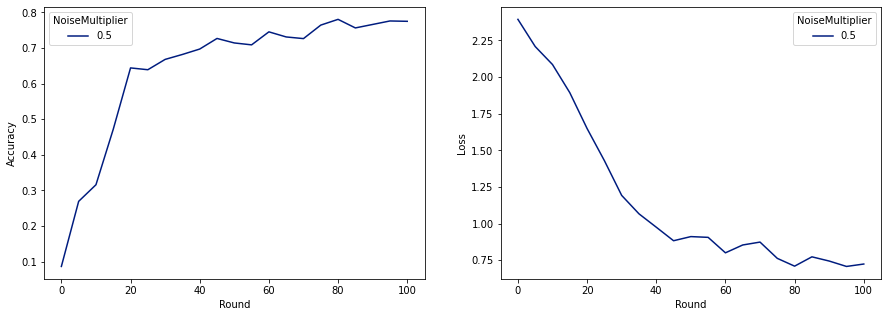

In [41]:
make_plot(train_A_df)

## 의뢰2
A ; CLIENTNUM, GENDER, Customer_Age

B ; Credit_Limit, Income_Category

C ; ATTRIBUTION_FLAG, Dependent_Count, Education_Level, Marital_Status, Native_Bays_Classifier_Attribution_Flag_Card_Category_mon1 & 2

In [5]:
A_col = ['CLIENTNUM', 'Gender', 'Customer_Age']
B_col = ['Credit_Limit', 'Income_Category']
C_col = ['Attrition_Flag', 'Dependent_count', 'Education_Level', 'Marital_Status', 
         'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
         'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']

data = pd.read_csv('BankChurners.csv')
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [6]:
Attrition_Flag, Attrition_Flag_label=data['Attrition_Flag'].factorize()
Gender, Gender_label=data['Gender'].factorize()
Education_Level, Education_Level_label=data['Education_Level'].factorize()
Marital_Status, Marital_Status_label=data['Marital_Status'].factorize()
Income_Category, Income_Category_label=data['Income_Category'].factorize()


print(Attrition_Flag, Attrition_Flag_label)
print(Gender, Gender_label)
print(Education_Level, Education_Level_label)
print(Marital_Status, Marital_Status_label)
print(Income_Category, Income_Category_label)



data['Attrition_Flag'] = Attrition_Flag
data['Gender'] = Gender
data['Education_Level'] = Education_Level
data['Marital_Status'] = Marital_Status
data['Income_Category'] = Income_Category


data

[0 0 0 ... 1 1 1] Index(['Existing Customer', 'Attrited Customer'], dtype='object')
[0 1 0 ... 1 0 1] Index(['M', 'F'], dtype='object')
[0 1 1 ... 0 1 1] Index(['High School', 'Graduate', 'Uneducated', 'Unknown', 'College',
       'Post-Graduate', 'Doctorate'],
      dtype='object')
[0 1 0 ... 0 2 0] Index(['Married', 'Single', 'Unknown', 'Divorced'], dtype='object')
[0 1 2 ... 1 3 1] Index(['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K',
       '$120K +', 'Unknown'],
      dtype='object')


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,0,45,0,3,0,0,0,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.999910
1,818770008,0,49,1,5,1,1,1,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.999940
2,713982108,0,51,0,3,1,0,2,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.999980
3,769911858,0,40,1,4,0,2,1,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.999870
4,709106358,0,40,0,3,2,0,0,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.999980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,772366833,0,50,0,2,1,1,3,Blue,40,...,4003.0,1851,2152.0,0.703,15476,117,0.857,0.462,0.000191,0.999810
10123,710638233,1,41,0,2,3,3,3,Blue,25,...,4277.0,2186,2091.0,0.804,8764,69,0.683,0.511,0.995270,0.004729
10124,716506083,1,44,1,1,0,0,1,Blue,36,...,5409.0,0,5409.0,0.819,10291,60,0.818,0.000,0.997880,0.002118
10125,717406983,1,30,0,2,1,2,3,Blue,36,...,5281.0,0,5281.0,0.535,8395,62,0.722,0.000,0.996710,0.003294


In [7]:
train_A_df = data[A_col]
train_B_df = data[B_col]
train_C_df = data[C_col]
train_C_df

,Attrition_Flag,Dependent_count,Education_Level,Marital_Status,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,0,3,0,0,0.000093,0.999910
1,0,5,1,1,0.000057,0.999940
2,0,3,1,0,0.000021,0.999980
3,0,4,0,2,0.000134,0.999870
4,0,3,2,0,0.000022,0.999980
...,...,...,...,...,...,...
10122,0,2,1,1,0.000191,0.999810
10123,1,2,3,3,0.995270,0.004729
10124,1,1,0,0,0.997880,0.002118
10125,1,2,1,2,0.996710,0.003294


In [8]:
from sklearn.model_selection import train_test_split

target_col = 'Credit_Limit'

use_data = train_A_df

if target_col in use_data.columns:
    use_data.drop([target_col], axis=1, inplace=True)

npX=use_data.to_numpy()
npY=data[target_col].to_numpy().reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(npX, npY, test_size=0.2)
p = X_train.shape[1]
print(p)

3


In [9]:
def my_model_fn(p):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(30, input_dim=p, activation=tf.nn.relu),
        tf.keras.layers.Dense(200, activation=tf.nn.relu),
        tf.keras.layers.Dense(200, activation=tf.nn.relu),
        tf.keras.layers.Dense(1)])
    return tff.learning.from_keras_model(keras_model=model,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                                         input_spec=X_test,
                                         metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])


def my_train(rounds,clients_per_round, noise_multiplier, divide_train_data, data_frame):
    aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(noise_multiplier, clients_per_round)
    learning_process = tff.learning.build_federated_averaging_process(my_model_fn(p),
                                                                      client_optimizer_fn=lambda: tf.keras.optimizers.SGD(0.01),
                                                                      server_optimizer_fn=lambda: tf.keras.optimizers.SGD(1.0, momentum=0.9),
                                                                      model_update_aggregation_factory=aggregation_factory)
    eval_process = tff.learning.build_federated_evaluation(my_model_fn(p))

    # Training loop.
    state = learning_process.initialize()
    for round in range(rounds):
        if round % 5 == 0:
            metrics = eval_process(state.model, [X_test])['eval']
            if round < 25 or round % 25 == 0:
                print(f'Round {round:3d}: {metrics}')
            data_frame = data_frame.append({'Round': round,
                                            'NoiseMultiplier': noise_multiplier,
                                            **metrics}, ignore_index=True)
        # Use selected clients for update.
        state, metrics = learning_process.next(state, divide_train_data)

    metrics = eval_process(state.model, [test_data])['eval']
    print(f'Round {rounds:3d}: {metrics}')
    data_frame = data_frame.append({'Round': rounds,
                                  'NoiseMultiplier': noise_multiplier,
                                  **metrics}, ignore_index=True)
    return data_frame

In [10]:
data_frame = pd.DataFrame()
rounds = 100

noise_multiplier= 0.75

train_B_df = my_train(rounds=rounds,clients_per_round=20, 
                      noise_multiplier=noise_multiplier, divide_train_data=X_train, data_frame=data_frame)

ValueError: The top-level structure in `input_spec` must contain exactly two top-level elements, as it must specify type information for both inputs to and predictions from the model. You passed input spec [[818459733         0        41]
 [718292283         1        52]
 [713442933         0        49]
 ...
 [716373483         1        48]
 [711205758         0        45]
 [712733958         1        46]].